In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

1.15.0
2.3.1


Using TensorFlow backend.


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


(15060, 41)

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100, use_bias=False,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(50, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(10, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               4100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5000      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_______________________________________

Epoch 36/100
30162/30162 [==============================] - 2s 70us/step - loss: 0.3832 - accuracy: 0.8171 - val_loss: 0.3461 - val_accuracy: 0.8444
Epoch 37/100
30162/30162 [==============================] - 2s 72us/step - loss: 0.3851 - accuracy: 0.8157 - val_loss: 0.3458 - val_accuracy: 0.8444
Epoch 38/100
30162/30162 [==============================] - 2s 73us/step - loss: 0.3841 - accuracy: 0.8175 - val_loss: 0.3462 - val_accuracy: 0.8456
Epoch 39/100
30162/30162 [==============================] - 2s 74us/step - loss: 0.3832 - accuracy: 0.8151 - val_loss: 0.3459 - val_accuracy: 0.8444
Epoch 40/100
30162/30162 [==============================] - 2s 69us/step - loss: 0.3841 - accuracy: 0.8168 - val_loss: 0.3456 - val_accuracy: 0.8445
Epoch 41/100
30162/30162 [==============================] - 2s 76us/step - loss: 0.3833 - accuracy: 0.8150 - val_loss: 0.3460 - val_accuracy: 0.8446
Epoch 42/100
30162/30162 [==============================] - 2s 77us/step - loss: 0.3829 - accuracy: 0.8186

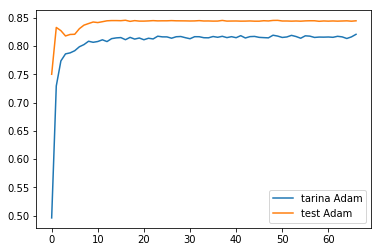

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj
 
```python
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

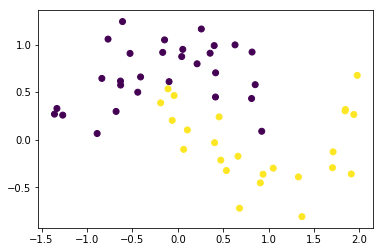

In [6]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [7]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_7 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.5094 - val_loss: 0.7139 - val_accuracy: 0.4468
Epoch 2/1000
53/53 [==============================] - 0s 546

53/53 [==============================] - 0s 565us/step - loss: 0.1896 - accuracy: 0.9057 - val_loss: 0.4487 - val_accuracy: 0.8298
Epoch 52/1000
53/53 [==============================] - 0s 565us/step - loss: 0.1900 - accuracy: 0.9245 - val_loss: 0.4320 - val_accuracy: 0.8298
Epoch 53/1000
53/53 [==============================] - 0s 583us/step - loss: 0.1924 - accuracy: 0.9057 - val_loss: 0.4341 - val_accuracy: 0.8298
Epoch 54/1000
53/53 [==============================] - 0s 527us/step - loss: 0.1917 - accuracy: 0.9057 - val_loss: 0.4605 - val_accuracy: 0.8298
Epoch 55/1000
53/53 [==============================] - 0s 565us/step - loss: 0.1861 - accuracy: 0.9434 - val_loss: 0.4751 - val_accuracy: 0.8298
Epoch 56/1000
53/53 [==============================] - 0s 565us/step - loss: 0.1840 - accuracy: 0.9245 - val_loss: 0.4669 - val_accuracy: 0.8298
Epoch 57/1000
53/53 [==============================] - 0s 565us/step - loss: 0.1826 - accuracy: 0.9245 - val_loss: 0.4661 - val_accuracy: 0.8298

53/53 [==============================] - 0s 546us/step - loss: 0.0734 - accuracy: 0.9811 - val_loss: 0.2205 - val_accuracy: 0.9149
Epoch 108/1000
53/53 [==============================] - 0s 527us/step - loss: 0.0683 - accuracy: 0.9811 - val_loss: 0.2179 - val_accuracy: 0.9149
Epoch 109/1000
53/53 [==============================] - 0s 546us/step - loss: 0.0659 - accuracy: 0.9811 - val_loss: 0.2223 - val_accuracy: 0.9149
Epoch 110/1000
53/53 [==============================] - 0s 640us/step - loss: 0.0657 - accuracy: 0.9623 - val_loss: 0.2226 - val_accuracy: 0.9149
Epoch 111/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0665 - accuracy: 0.9623 - val_loss: 0.2205 - val_accuracy: 0.9149
Epoch 112/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0611 - accuracy: 0.9811 - val_loss: 0.1954 - val_accuracy: 0.9149
Epoch 113/1000
53/53 [==============================] - 0s 527us/step - loss: 0.0577 - accuracy: 1.0000 - val_loss: 0.1897 - val_accuracy: 

53/53 [==============================] - 0s 565us/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.1883 - val_accuracy: 0.9149
Epoch 164/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.1857 - val_accuracy: 0.9149
Epoch 165/1000
53/53 [==============================] - 0s 527us/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.1855 - val_accuracy: 0.9149
Epoch 166/1000
53/53 [==============================] - 0s 546us/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.1918 - val_accuracy: 0.9149
Epoch 167/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.2016 - val_accuracy: 0.9362
Epoch 168/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.2034 - val_accuracy: 0.9362
Epoch 169/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.2012 - val_accuracy: 

53/53 [==============================] - 0s 546us/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.2036 - val_accuracy: 0.9149
Epoch 220/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.2037 - val_accuracy: 0.8936
Epoch 221/1000
53/53 [==============================] - 0s 527us/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.2061 - val_accuracy: 0.8936
Epoch 222/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.2088 - val_accuracy: 0.8936
Epoch 223/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.2110 - val_accuracy: 0.9149
Epoch 224/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.2075 - val_accuracy: 0.8936
Epoch 225/1000
53/53 [==============================] - 0s 527us/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.2055 - val_accuracy: 

53/53 [==============================] - 0s 546us/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2137 - val_accuracy: 0.9362
Epoch 276/1000
53/53 [==============================] - 0s 602us/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.2147 - val_accuracy: 0.9149
Epoch 277/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.2146 - val_accuracy: 0.9149
Epoch 278/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2147 - val_accuracy: 0.9149
Epoch 279/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2153 - val_accuracy: 0.9149
Epoch 280/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2153 - val_accuracy: 0.9149
Epoch 281/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2152 - val_accuracy: 

53/53 [==============================] - 0s 640us/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2279 - val_accuracy: 0.9149
Epoch 332/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2280 - val_accuracy: 0.9149
Epoch 333/1000
53/53 [==============================] - 0s 715us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2282 - val_accuracy: 0.9149
Epoch 334/1000
53/53 [==============================] - 0s 847us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2271 - val_accuracy: 0.9149
Epoch 335/1000
53/53 [==============================] - 0s 979us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2272 - val_accuracy: 0.9149
Epoch 336/1000
53/53 [==============================] - 0s 903us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2272 - val_accuracy: 0.9149
Epoch 337/1000
53/53 [==============================] - 0s 591us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2272 - val_accuracy: 

53/53 [==============================] - 0s 583us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2460 - val_accuracy: 0.9149
Epoch 388/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2446 - val_accuracy: 0.9149
Epoch 389/1000
53/53 [==============================] - 0s 583us/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2441 - val_accuracy: 0.9149
Epoch 390/1000
53/53 [==============================] - 0s 527us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2454 - val_accuracy: 0.9149
Epoch 391/1000
53/53 [==============================] - 0s 546us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2464 - val_accuracy: 0.9149
Epoch 392/1000
53/53 [==============================] - 0s 546us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2475 - val_accuracy: 0.9149
Epoch 393/1000
53/53 [==============================] - 0s 565us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2481 - val_accuracy: 

53/53 [==============================] - 0s 734us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2566 - val_accuracy: 0.9149
Epoch 444/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2585 - val_accuracy: 0.9149
Epoch 445/1000
53/53 [==============================] - 0s 696us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2593 - val_accuracy: 0.9149
Epoch 446/1000
53/53 [==============================] - 0s 828us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2589 - val_accuracy: 0.9149
Epoch 447/1000
53/53 [==============================] - 0s 715us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2578 - val_accuracy: 0.9149
Epoch 448/1000
53/53 [==============================] - 0s 847us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2562 - val_accuracy: 0.9149
Epoch 449/1000
53/53 [==============================] - 0s 659us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2562 - val_accuracy: 

53/53 [==============================] - 0s 772us/step - loss: 8.3334e-04 - accuracy: 1.0000 - val_loss: 0.2746 - val_accuracy: 0.9149
Epoch 499/1000
53/53 [==============================] - 0s 677us/step - loss: 8.2776e-04 - accuracy: 1.0000 - val_loss: 0.2755 - val_accuracy: 0.9149
Epoch 500/1000
53/53 [==============================] - 0s 677us/step - loss: 8.5253e-04 - accuracy: 1.0000 - val_loss: 0.2765 - val_accuracy: 0.9149
Epoch 501/1000
53/53 [==============================] - 0s 866us/step - loss: 8.1870e-04 - accuracy: 1.0000 - val_loss: 0.2764 - val_accuracy: 0.9149
Epoch 502/1000
53/53 [==============================] - 0s 847us/step - loss: 8.2896e-04 - accuracy: 1.0000 - val_loss: 0.2763 - val_accuracy: 0.9149
Epoch 503/1000
53/53 [==============================] - 0s 922us/step - loss: 8.1274e-04 - accuracy: 1.0000 - val_loss: 0.2755 - val_accuracy: 0.9149
Epoch 504/1000
53/53 [==============================] - 0s 753us/step - loss: 8.1374e-04 - accuracy: 1.0000 - val_l

Epoch 553/1000
53/53 [==============================] - 0s 677us/step - loss: 6.2862e-04 - accuracy: 1.0000 - val_loss: 0.2874 - val_accuracy: 0.9149
Epoch 554/1000
53/53 [==============================] - 0s 790us/step - loss: 6.1605e-04 - accuracy: 1.0000 - val_loss: 0.2893 - val_accuracy: 0.9149
Epoch 555/1000
53/53 [==============================] - 0s 790us/step - loss: 6.2389e-04 - accuracy: 1.0000 - val_loss: 0.2916 - val_accuracy: 0.9149
Epoch 556/1000
53/53 [==============================] - 0s 790us/step - loss: 6.3692e-04 - accuracy: 1.0000 - val_loss: 0.2929 - val_accuracy: 0.9149
Epoch 557/1000
53/53 [==============================] - 0s 599us/step - loss: 6.4348e-04 - accuracy: 1.0000 - val_loss: 0.2930 - val_accuracy: 0.9149
Epoch 558/1000
53/53 [==============================] - 0s 772us/step - loss: 6.5065e-04 - accuracy: 1.0000 - val_loss: 0.2921 - val_accuracy: 0.9149
Epoch 559/1000
53/53 [==============================] - 0s 647us/step - loss: 6.1838e-04 - accuracy:

53/53 [==============================] - 0s 734us/step - loss: 5.0690e-04 - accuracy: 1.0000 - val_loss: 0.2978 - val_accuracy: 0.9149
Epoch 608/1000
53/53 [==============================] - 0s 677us/step - loss: 4.9849e-04 - accuracy: 1.0000 - val_loss: 0.2976 - val_accuracy: 0.9149
Epoch 609/1000
53/53 [==============================] - 0s 790us/step - loss: 4.8692e-04 - accuracy: 1.0000 - val_loss: 0.2987 - val_accuracy: 0.9149
Epoch 610/1000
53/53 [==============================] - 0s 583us/step - loss: 5.0100e-04 - accuracy: 1.0000 - val_loss: 0.2999 - val_accuracy: 0.9149
Epoch 611/1000
53/53 [==============================] - 0s 565us/step - loss: 4.8360e-04 - accuracy: 1.0000 - val_loss: 0.2997 - val_accuracy: 0.9149
Epoch 612/1000
53/53 [==============================] - 0s 564us/step - loss: 4.9464e-04 - accuracy: 1.0000 - val_loss: 0.2993 - val_accuracy: 0.9149
Epoch 613/1000
53/53 [==============================] - 0s 546us/step - loss: 4.7802e-04 - accuracy: 1.0000 - val_l

Epoch 662/1000
53/53 [==============================] - 0s 565us/step - loss: 3.9623e-04 - accuracy: 1.0000 - val_loss: 0.3081 - val_accuracy: 0.9149
Epoch 663/1000
53/53 [==============================] - 0s 565us/step - loss: 3.9267e-04 - accuracy: 1.0000 - val_loss: 0.3090 - val_accuracy: 0.9149
Epoch 664/1000
53/53 [==============================] - 0s 583us/step - loss: 3.9281e-04 - accuracy: 1.0000 - val_loss: 0.3097 - val_accuracy: 0.9149
Epoch 665/1000
53/53 [==============================] - 0s 565us/step - loss: 4.0498e-04 - accuracy: 1.0000 - val_loss: 0.3115 - val_accuracy: 0.9149
Epoch 666/1000
53/53 [==============================] - 0s 527us/step - loss: 3.8640e-04 - accuracy: 1.0000 - val_loss: 0.3118 - val_accuracy: 0.9149
Epoch 667/1000
53/53 [==============================] - 0s 546us/step - loss: 3.9333e-04 - accuracy: 1.0000 - val_loss: 0.3115 - val_accuracy: 0.9149
Epoch 668/1000
53/53 [==============================] - 0s 583us/step - loss: 3.8297e-04 - accuracy:

53/53 [==============================] - 0s 621us/step - loss: 3.1716e-04 - accuracy: 1.0000 - val_loss: 0.3188 - val_accuracy: 0.9149
Epoch 717/1000
53/53 [==============================] - 0s 508us/step - loss: 3.1622e-04 - accuracy: 1.0000 - val_loss: 0.3180 - val_accuracy: 0.9149
Epoch 718/1000
53/53 [==============================] - 0s 527us/step - loss: 3.1917e-04 - accuracy: 1.0000 - val_loss: 0.3179 - val_accuracy: 0.9149
Epoch 719/1000
53/53 [==============================] - 0s 565us/step - loss: 3.1730e-04 - accuracy: 1.0000 - val_loss: 0.3175 - val_accuracy: 0.9149
Epoch 720/1000
53/53 [==============================] - 0s 546us/step - loss: 3.1728e-04 - accuracy: 1.0000 - val_loss: 0.3180 - val_accuracy: 0.9149
Epoch 721/1000
53/53 [==============================] - 0s 565us/step - loss: 3.2166e-04 - accuracy: 1.0000 - val_loss: 0.3189 - val_accuracy: 0.9149
Epoch 722/1000
53/53 [==============================] - 0s 546us/step - loss: 3.1687e-04 - accuracy: 1.0000 - val_l

Epoch 771/1000
53/53 [==============================] - 0s 546us/step - loss: 2.6179e-04 - accuracy: 1.0000 - val_loss: 0.3314 - val_accuracy: 0.9149
Epoch 772/1000
53/53 [==============================] - 0s 565us/step - loss: 2.7070e-04 - accuracy: 1.0000 - val_loss: 0.3325 - val_accuracy: 0.9149
Epoch 773/1000
53/53 [==============================] - 0s 546us/step - loss: 2.6632e-04 - accuracy: 1.0000 - val_loss: 0.3324 - val_accuracy: 0.9149
Epoch 774/1000
53/53 [==============================] - 0s 583us/step - loss: 2.6935e-04 - accuracy: 1.0000 - val_loss: 0.3310 - val_accuracy: 0.9149
Epoch 775/1000
53/53 [==============================] - 0s 565us/step - loss: 2.5813e-04 - accuracy: 1.0000 - val_loss: 0.3308 - val_accuracy: 0.9149
Epoch 776/1000
53/53 [==============================] - 0s 527us/step - loss: 2.6323e-04 - accuracy: 1.0000 - val_loss: 0.3303 - val_accuracy: 0.9149
Epoch 777/1000
53/53 [==============================] - 0s 583us/step - loss: 2.5901e-04 - accuracy:

53/53 [==============================] - 0s 546us/step - loss: 2.2214e-04 - accuracy: 1.0000 - val_loss: 0.3388 - val_accuracy: 0.9149
Epoch 826/1000
53/53 [==============================] - 0s 583us/step - loss: 2.1951e-04 - accuracy: 1.0000 - val_loss: 0.3382 - val_accuracy: 0.9149
Epoch 827/1000
53/53 [==============================] - 0s 583us/step - loss: 2.1903e-04 - accuracy: 1.0000 - val_loss: 0.3377 - val_accuracy: 0.9149
Epoch 828/1000
53/53 [==============================] - 0s 546us/step - loss: 2.1573e-04 - accuracy: 1.0000 - val_loss: 0.3366 - val_accuracy: 0.9149
Epoch 829/1000
53/53 [==============================] - 0s 583us/step - loss: 2.1653e-04 - accuracy: 1.0000 - val_loss: 0.3351 - val_accuracy: 0.9149
Epoch 830/1000
53/53 [==============================] - 0s 583us/step - loss: 2.1756e-04 - accuracy: 1.0000 - val_loss: 0.3344 - val_accuracy: 0.9149
Epoch 831/1000
53/53 [==============================] - 0s 583us/step - loss: 2.2837e-04 - accuracy: 1.0000 - val_l

Epoch 880/1000
53/53 [==============================] - 0s 546us/step - loss: 1.9182e-04 - accuracy: 1.0000 - val_loss: 0.3490 - val_accuracy: 0.9149
Epoch 881/1000
53/53 [==============================] - 0s 489us/step - loss: 1.8859e-04 - accuracy: 1.0000 - val_loss: 0.3489 - val_accuracy: 0.9149
Epoch 882/1000
53/53 [==============================] - 0s 565us/step - loss: 1.8518e-04 - accuracy: 1.0000 - val_loss: 0.3477 - val_accuracy: 0.9149
Epoch 883/1000
53/53 [==============================] - 0s 602us/step - loss: 1.8381e-04 - accuracy: 1.0000 - val_loss: 0.3468 - val_accuracy: 0.9149
Epoch 884/1000
53/53 [==============================] - 0s 565us/step - loss: 1.8429e-04 - accuracy: 1.0000 - val_loss: 0.3454 - val_accuracy: 0.9149
Epoch 885/1000
53/53 [==============================] - 0s 565us/step - loss: 1.8530e-04 - accuracy: 1.0000 - val_loss: 0.3449 - val_accuracy: 0.9149
Epoch 886/1000
53/53 [==============================] - 0s 527us/step - loss: 1.8894e-04 - accuracy:

53/53 [==============================] - 0s 546us/step - loss: 1.6025e-04 - accuracy: 1.0000 - val_loss: 0.3572 - val_accuracy: 0.9149
Epoch 935/1000
53/53 [==============================] - 0s 546us/step - loss: 1.6141e-04 - accuracy: 1.0000 - val_loss: 0.3578 - val_accuracy: 0.9149
Epoch 936/1000
53/53 [==============================] - 0s 565us/step - loss: 1.6072e-04 - accuracy: 1.0000 - val_loss: 0.3586 - val_accuracy: 0.9149
Epoch 937/1000
53/53 [==============================] - 0s 583us/step - loss: 1.6111e-04 - accuracy: 1.0000 - val_loss: 0.3588 - val_accuracy: 0.9149
Epoch 938/1000
53/53 [==============================] - 0s 565us/step - loss: 1.6296e-04 - accuracy: 1.0000 - val_loss: 0.3586 - val_accuracy: 0.9149
Epoch 939/1000
53/53 [==============================] - 0s 602us/step - loss: 1.5946e-04 - accuracy: 1.0000 - val_loss: 0.3587 - val_accuracy: 0.9149
Epoch 940/1000
53/53 [==============================] - 0s 602us/step - loss: 1.5981e-04 - accuracy: 1.0000 - val_l

Epoch 989/1000
53/53 [==============================] - 0s 526us/step - loss: 1.3891e-04 - accuracy: 1.0000 - val_loss: 0.3632 - val_accuracy: 0.9149
Epoch 990/1000
53/53 [==============================] - 0s 565us/step - loss: 1.4137e-04 - accuracy: 1.0000 - val_loss: 0.3625 - val_accuracy: 0.9149
Epoch 991/1000
53/53 [==============================] - 0s 602us/step - loss: 1.3808e-04 - accuracy: 1.0000 - val_loss: 0.3628 - val_accuracy: 0.9149
Epoch 992/1000
53/53 [==============================] - 0s 546us/step - loss: 1.3765e-04 - accuracy: 1.0000 - val_loss: 0.3635 - val_accuracy: 0.9149
Epoch 993/1000
53/53 [==============================] - 0s 546us/step - loss: 1.3664e-04 - accuracy: 1.0000 - val_loss: 0.3641 - val_accuracy: 0.9149
Epoch 994/1000
53/53 [==============================] - 0s 583us/step - loss: 1.3619e-04 - accuracy: 1.0000 - val_loss: 0.3646 - val_accuracy: 0.9149
Epoch 995/1000
53/53 [==============================] - 0s 546us/step - loss: 1.3589e-04 - accuracy:

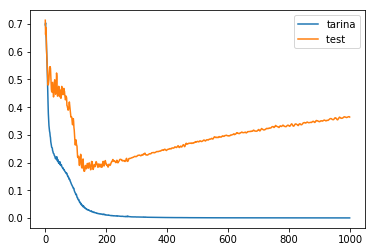

In [8]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


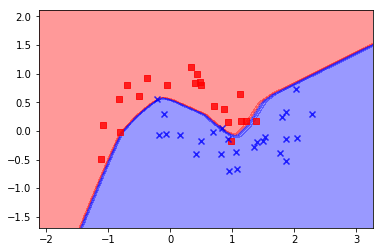

In [9]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [10]:
from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1 = History()
model = Sequential()
model.add(Dense(1000, use_bias=False,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(500, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(200, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_1])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1000)              2000      
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000)              4000      
_________________________________________________________________
activation_4 (Activation)    (None, 1000)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               500000    
_________________________________________________________________
batch_normalization_5 (Batch (None, 500)               2000      
_________________________________________________________________
activation_5 (Activation)    (None, 500)              

Epoch 43/1000
53/53 [==============================] - 0s 847us/step - loss: 0.2847 - accuracy: 0.8679 - val_loss: 0.5920 - val_accuracy: 0.7447
Epoch 44/1000
53/53 [==============================] - 0s 1ms/step - loss: 0.2647 - accuracy: 0.8679 - val_loss: 0.5919 - val_accuracy: 0.7447
Epoch 45/1000
53/53 [==============================] - 0s 847us/step - loss: 0.3058 - accuracy: 0.9245 - val_loss: 0.5909 - val_accuracy: 0.7447
Epoch 46/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2706 - accuracy: 0.8679 - val_loss: 0.5914 - val_accuracy: 0.7447
Epoch 47/1000
53/53 [==============================] - 0s 828us/step - loss: 0.2657 - accuracy: 0.8302 - val_loss: 0.5940 - val_accuracy: 0.7234
Epoch 48/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3567 - accuracy: 0.8679 - val_loss: 0.5975 - val_accuracy: 0.7234
Epoch 49/1000
53/53 [==============================] - 0s 677us/step - loss: 0.3105 - accuracy: 0.9057 - val_loss: 0.5998 - val_accu

53/53 [==============================] - 0s 753us/step - loss: 0.2486 - accuracy: 0.9057 - val_loss: 0.5005 - val_accuracy: 0.8085
Epoch 100/1000
53/53 [==============================] - 0s 857us/step - loss: 0.3511 - accuracy: 0.8491 - val_loss: 0.4978 - val_accuracy: 0.7872
Epoch 101/1000
53/53 [==============================] - 0s 772us/step - loss: 0.3018 - accuracy: 0.8868 - val_loss: 0.4959 - val_accuracy: 0.7872
Epoch 102/1000
53/53 [==============================] - 0s 1ms/step - loss: 0.2403 - accuracy: 0.9057 - val_loss: 0.4947 - val_accuracy: 0.7872
Epoch 103/1000
53/53 [==============================] - 0s 841us/step - loss: 0.2250 - accuracy: 0.9057 - val_loss: 0.4954 - val_accuracy: 0.7872
Epoch 104/1000
53/53 [==============================] - 0s 828us/step - loss: 0.4115 - accuracy: 0.8491 - val_loss: 0.4966 - val_accuracy: 0.7660
Epoch 105/1000
53/53 [==============================] - 0s 845us/step - loss: 0.3407 - accuracy: 0.8679 - val_loss: 0.4973 - val_accuracy: 0.

53/53 [==============================] - 0s 790us/step - loss: 0.3292 - accuracy: 0.8679 - val_loss: 0.4918 - val_accuracy: 0.7447
Epoch 156/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3083 - accuracy: 0.8679 - val_loss: 0.4898 - val_accuracy: 0.7447
Epoch 157/1000
53/53 [==============================] - 0s 752us/step - loss: 0.2770 - accuracy: 0.9245 - val_loss: 0.4872 - val_accuracy: 0.7447
Epoch 158/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2866 - accuracy: 0.9057 - val_loss: 0.4864 - val_accuracy: 0.7447
Epoch 159/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2762 - accuracy: 0.9057 - val_loss: 0.4877 - val_accuracy: 0.7447
Epoch 160/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2872 - accuracy: 0.8679 - val_loss: 0.4884 - val_accuracy: 0.7447
Epoch 161/1000
53/53 [==============================] - 0s 866us/step - loss: 0.2523 - accuracy: 0.8868 - val_loss: 0.4914 - val_accuracy: 

53/53 [==============================] - 0s 866us/step - loss: 0.2999 - accuracy: 0.8679 - val_loss: 0.4676 - val_accuracy: 0.7447
Epoch 212/1000
53/53 [==============================] - 0s 866us/step - loss: 0.2523 - accuracy: 0.8868 - val_loss: 0.4689 - val_accuracy: 0.7447
Epoch 213/1000
53/53 [==============================] - 0s 979us/step - loss: 0.3107 - accuracy: 0.9057 - val_loss: 0.4706 - val_accuracy: 0.7447
Epoch 214/1000
53/53 [==============================] - 0s 828us/step - loss: 0.2578 - accuracy: 0.8679 - val_loss: 0.4699 - val_accuracy: 0.7660
Epoch 215/1000
53/53 [==============================] - 0s 790us/step - loss: 0.2933 - accuracy: 0.9057 - val_loss: 0.4701 - val_accuracy: 0.7660
Epoch 216/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2750 - accuracy: 0.8868 - val_loss: 0.4674 - val_accuracy: 0.7660
Epoch 217/1000
53/53 [==============================] - 0s 790us/step - loss: 0.3747 - accuracy: 0.7736 - val_loss: 0.4635 - val_accuracy: 

53/53 [==============================] - 0s 753us/step - loss: 0.3045 - accuracy: 0.8679 - val_loss: 0.4891 - val_accuracy: 0.7660
Epoch 268/1000
53/53 [==============================] - 0s 772us/step - loss: 0.2472 - accuracy: 0.8679 - val_loss: 0.4897 - val_accuracy: 0.7660
Epoch 269/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3414 - accuracy: 0.8491 - val_loss: 0.4884 - val_accuracy: 0.7660
Epoch 270/1000
53/53 [==============================] - 0s 790us/step - loss: 0.2608 - accuracy: 0.9245 - val_loss: 0.4891 - val_accuracy: 0.7660
Epoch 271/1000
53/53 [==============================] - 0s 772us/step - loss: 0.2443 - accuracy: 0.8868 - val_loss: 0.4900 - val_accuracy: 0.7660
Epoch 272/1000
53/53 [==============================] - 0s 790us/step - loss: 0.3005 - accuracy: 0.8679 - val_loss: 0.4865 - val_accuracy: 0.7660
Epoch 273/1000
53/53 [==============================] - 0s 876us/step - loss: 0.2445 - accuracy: 0.8868 - val_loss: 0.4803 - val_accuracy: 

53/53 [==============================] - 0s 847us/step - loss: 0.3041 - accuracy: 0.8868 - val_loss: 0.4437 - val_accuracy: 0.8085
Epoch 324/1000
53/53 [==============================] - 0s 790us/step - loss: 0.2765 - accuracy: 0.8868 - val_loss: 0.4472 - val_accuracy: 0.8085
Epoch 325/1000
53/53 [==============================] - 0s 809us/step - loss: 0.3110 - accuracy: 0.8868 - val_loss: 0.4496 - val_accuracy: 0.8085
Epoch 326/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3031 - accuracy: 0.9057 - val_loss: 0.4484 - val_accuracy: 0.8085
Epoch 327/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2831 - accuracy: 0.8679 - val_loss: 0.4490 - val_accuracy: 0.8085
Epoch 328/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2225 - accuracy: 0.9057 - val_loss: 0.4504 - val_accuracy: 0.8085
Epoch 329/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2484 - accuracy: 0.9057 - val_loss: 0.4496 - val_accuracy: 

53/53 [==============================] - 0s 828us/step - loss: 0.2971 - accuracy: 0.8868 - val_loss: 0.4419 - val_accuracy: 0.8085
Epoch 380/1000
53/53 [==============================] - 0s 753us/step - loss: 0.3115 - accuracy: 0.8679 - val_loss: 0.4402 - val_accuracy: 0.8085
Epoch 381/1000
53/53 [==============================] - 0s 847us/step - loss: 0.2124 - accuracy: 0.9434 - val_loss: 0.4354 - val_accuracy: 0.8298
Epoch 382/1000
53/53 [==============================] - 0s 890us/step - loss: 0.2339 - accuracy: 0.9057 - val_loss: 0.4321 - val_accuracy: 0.8298
Epoch 383/1000
53/53 [==============================] - 0s 854us/step - loss: 0.2327 - accuracy: 0.9245 - val_loss: 0.4285 - val_accuracy: 0.8298
Epoch 384/1000
53/53 [==============================] - 0s 941us/step - loss: 0.3082 - accuracy: 0.9245 - val_loss: 0.4284 - val_accuracy: 0.8298
Epoch 385/1000
53/53 [==============================] - 0s 941us/step - loss: 0.2711 - accuracy: 0.8679 - val_loss: 0.4290 - val_accuracy: 

53/53 [==============================] - 0s 895us/step - loss: 0.2428 - accuracy: 0.8868 - val_loss: 0.4047 - val_accuracy: 0.8298
Epoch 436/1000
53/53 [==============================] - 0s 885us/step - loss: 0.2662 - accuracy: 0.8491 - val_loss: 0.4069 - val_accuracy: 0.8298
Epoch 437/1000
53/53 [==============================] - 0s 1ms/step - loss: 0.3298 - accuracy: 0.8302 - val_loss: 0.4116 - val_accuracy: 0.8298
Epoch 438/1000
53/53 [==============================] - 0s 790us/step - loss: 0.2890 - accuracy: 0.8679 - val_loss: 0.4168 - val_accuracy: 0.8085
Epoch 439/1000
53/53 [==============================] - 0s 790us/step - loss: 0.1949 - accuracy: 0.9057 - val_loss: 0.4212 - val_accuracy: 0.8085
Epoch 440/1000
53/53 [==============================] - 0s 941us/step - loss: 0.2486 - accuracy: 0.9057 - val_loss: 0.4262 - val_accuracy: 0.8085
Epoch 441/1000
53/53 [==============================] - 0s 903us/step - loss: 0.2665 - accuracy: 0.8868 - val_loss: 0.4329 - val_accuracy: 0.

53/53 [==============================] - 0s 677us/step - loss: 0.2200 - accuracy: 0.8868 - val_loss: 0.3967 - val_accuracy: 0.8085
Epoch 491/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2175 - accuracy: 0.9057 - val_loss: 0.3976 - val_accuracy: 0.8085
Epoch 492/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2906 - accuracy: 0.8868 - val_loss: 0.3979 - val_accuracy: 0.8085
Epoch 493/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2389 - accuracy: 0.8868 - val_loss: 0.4007 - val_accuracy: 0.8085
Epoch 494/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2880 - accuracy: 0.9057 - val_loss: 0.4052 - val_accuracy: 0.8085
Epoch 495/1000
53/53 [==============================] - 0s 677us/step - loss: 0.1684 - accuracy: 0.9434 - val_loss: 0.4066 - val_accuracy: 0.8085
Epoch 496/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2726 - accuracy: 0.8868 - val_loss: 0.4044 - val_accuracy: 

Epoch 546/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3461 - accuracy: 0.8113 - val_loss: 0.3284 - val_accuracy: 0.8723
Epoch 547/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2159 - accuracy: 0.9245 - val_loss: 0.3379 - val_accuracy: 0.8723
Epoch 548/1000
53/53 [==============================] - 0s 621us/step - loss: 0.2639 - accuracy: 0.9057 - val_loss: 0.3526 - val_accuracy: 0.8723
Epoch 549/1000
53/53 [==============================] - 0s 734us/step - loss: 0.1888 - accuracy: 0.9057 - val_loss: 0.3650 - val_accuracy: 0.8511
Epoch 550/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3176 - accuracy: 0.8679 - val_loss: 0.3731 - val_accuracy: 0.8511
Epoch 551/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2758 - accuracy: 0.8868 - val_loss: 0.3786 - val_accuracy: 0.8511
Epoch 552/1000
53/53 [==============================] - 0s 677us/step - loss: 0.1884 - accuracy: 0.9434 - val_loss: 0.3775 -

53/53 [==============================] - 0s 696us/step - loss: 0.3818 - accuracy: 0.8868 - val_loss: 0.2809 - val_accuracy: 0.8298
Epoch 603/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2389 - accuracy: 0.8868 - val_loss: 0.2810 - val_accuracy: 0.8511
Epoch 604/1000
53/53 [==============================] - 0s 866us/step - loss: 0.2503 - accuracy: 0.9057 - val_loss: 0.2842 - val_accuracy: 0.8723
Epoch 605/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2526 - accuracy: 0.8868 - val_loss: 0.2913 - val_accuracy: 0.8723
Epoch 606/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2066 - accuracy: 0.9057 - val_loss: 0.2982 - val_accuracy: 0.8723
Epoch 607/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2072 - accuracy: 0.9434 - val_loss: 0.3021 - val_accuracy: 0.8723
Epoch 608/1000
53/53 [==============================] - 0s 715us/step - loss: 0.1836 - accuracy: 0.9245 - val_loss: 0.3051 - val_accuracy: 

53/53 [==============================] - 0s 659us/step - loss: 0.2236 - accuracy: 0.8868 - val_loss: 0.3591 - val_accuracy: 0.8723
Epoch 659/1000
53/53 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.90 - 0s 715us/step - loss: 0.1969 - accuracy: 0.9057 - val_loss: 0.3747 - val_accuracy: 0.8511
Epoch 660/1000
53/53 [==============================] - 0s 659us/step - loss: 0.3153 - accuracy: 0.9057 - val_loss: 0.3921 - val_accuracy: 0.8511
Epoch 661/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2121 - accuracy: 0.9434 - val_loss: 0.3997 - val_accuracy: 0.8511
Epoch 662/1000
53/53 [==============================] - 0s 677us/step - loss: 0.3147 - accuracy: 0.8679 - val_loss: 0.4036 - val_accuracy: 0.8511
Epoch 663/1000
53/53 [==============================] - 0s 640us/step - loss: 0.1538 - accuracy: 0.9434 - val_loss: 0.4098 - val_accuracy: 0.8511
Epoch 664/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2592 - accuracy: 

Epoch 714/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2330 - accuracy: 0.9057 - val_loss: 0.3047 - val_accuracy: 0.8723
Epoch 715/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2677 - accuracy: 0.8868 - val_loss: 0.3035 - val_accuracy: 0.8723
Epoch 716/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3591 - accuracy: 0.8302 - val_loss: 0.3026 - val_accuracy: 0.8723
Epoch 717/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2143 - accuracy: 0.9245 - val_loss: 0.3011 - val_accuracy: 0.8723
Epoch 718/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3322 - accuracy: 0.8302 - val_loss: 0.3021 - val_accuracy: 0.8723
Epoch 719/1000
53/53 [==============================] - 0s 640us/step - loss: 0.2158 - accuracy: 0.8868 - val_loss: 0.3065 - val_accuracy: 0.8723
Epoch 720/1000
53/53 [==============================] - 0s 677us/step - loss: 0.1470 - accuracy: 0.9434 - val_loss: 0.3068 -

53/53 [==============================] - 0s 696us/step - loss: 0.2036 - accuracy: 0.8868 - val_loss: 0.2943 - val_accuracy: 0.8723
Epoch 771/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3444 - accuracy: 0.7925 - val_loss: 0.2949 - val_accuracy: 0.8723
Epoch 772/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2186 - accuracy: 0.8679 - val_loss: 0.2906 - val_accuracy: 0.8723
Epoch 773/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2174 - accuracy: 0.9245 - val_loss: 0.2835 - val_accuracy: 0.8723
Epoch 774/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2241 - accuracy: 0.9245 - val_loss: 0.2796 - val_accuracy: 0.8723
Epoch 775/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2259 - accuracy: 0.9057 - val_loss: 0.2735 - val_accuracy: 0.8723
Epoch 776/1000
53/53 [==============================] - 0s 659us/step - loss: 0.1842 - accuracy: 0.9434 - val_loss: 0.2670 - val_accuracy: 

53/53 [==============================] - 0s 696us/step - loss: 0.2594 - accuracy: 0.9057 - val_loss: 0.3048 - val_accuracy: 0.8723
Epoch 827/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2560 - accuracy: 0.8868 - val_loss: 0.3149 - val_accuracy: 0.8723
Epoch 828/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2148 - accuracy: 0.9245 - val_loss: 0.3244 - val_accuracy: 0.8723
Epoch 829/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2948 - accuracy: 0.8868 - val_loss: 0.3272 - val_accuracy: 0.8723
Epoch 830/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2789 - accuracy: 0.9245 - val_loss: 0.3254 - val_accuracy: 0.8723
Epoch 831/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2263 - accuracy: 0.9245 - val_loss: 0.3211 - val_accuracy: 0.8723
Epoch 832/1000
53/53 [==============================] - 0s 677us/step - loss: 0.1661 - accuracy: 0.9245 - val_loss: 0.3107 - val_accuracy: 

53/53 [==============================] - 0s 753us/step - loss: 0.1885 - accuracy: 0.9245 - val_loss: 0.3024 - val_accuracy: 0.8723
Epoch 883/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2385 - accuracy: 0.8679 - val_loss: 0.2972 - val_accuracy: 0.8723
Epoch 884/1000
53/53 [==============================] - 0s 677us/step - loss: 0.1571 - accuracy: 0.9057 - val_loss: 0.2920 - val_accuracy: 0.8723
Epoch 885/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2521 - accuracy: 0.8868 - val_loss: 0.2812 - val_accuracy: 0.8723
Epoch 886/1000
53/53 [==============================] - 0s 659us/step - loss: 0.1543 - accuracy: 0.9811 - val_loss: 0.2731 - val_accuracy: 0.8723
Epoch 887/1000
53/53 [==============================] - 0s 696us/step - loss: 0.4353 - accuracy: 0.8491 - val_loss: 0.2775 - val_accuracy: 0.8723
Epoch 888/1000
53/53 [==============================] - 0s 659us/step - loss: 0.1606 - accuracy: 0.9245 - val_loss: 0.2839 - val_accuracy: 

53/53 [==============================] - 0s 677us/step - loss: 0.1620 - accuracy: 0.9434 - val_loss: 0.2717 - val_accuracy: 0.8723
Epoch 939/1000
53/53 [==============================] - 0s 678us/step - loss: 0.2838 - accuracy: 0.8679 - val_loss: 0.2692 - val_accuracy: 0.8723
Epoch 940/1000
53/53 [==============================] - 0s 809us/step - loss: 0.2060 - accuracy: 0.9057 - val_loss: 0.2673 - val_accuracy: 0.8723
Epoch 941/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2709 - accuracy: 0.8868 - val_loss: 0.2700 - val_accuracy: 0.8723
Epoch 942/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2004 - accuracy: 0.9245 - val_loss: 0.2784 - val_accuracy: 0.8723
Epoch 943/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2408 - accuracy: 0.9057 - val_loss: 0.2858 - val_accuracy: 0.8723
Epoch 944/1000
53/53 [==============================] - 0s 659us/step - loss: 0.2305 - accuracy: 0.9057 - val_loss: 0.2852 - val_accuracy: 

53/53 [==============================] - 0s 659us/step - loss: 0.1380 - accuracy: 0.9623 - val_loss: 0.3029 - val_accuracy: 0.8723
Epoch 995/1000
53/53 [==============================] - 0s 640us/step - loss: 0.1235 - accuracy: 0.9623 - val_loss: 0.3031 - val_accuracy: 0.8723
Epoch 996/1000
53/53 [==============================] - 0s 715us/step - loss: 0.1527 - accuracy: 0.9057 - val_loss: 0.3074 - val_accuracy: 0.8723
Epoch 997/1000
53/53 [==============================] - 0s 677us/step - loss: 0.1253 - accuracy: 0.9623 - val_loss: 0.3100 - val_accuracy: 0.8723
Epoch 998/1000
53/53 [==============================] - 0s 677us/step - loss: 0.2027 - accuracy: 0.9057 - val_loss: 0.3093 - val_accuracy: 0.8723
Epoch 999/1000
53/53 [==============================] - 0s 659us/step - loss: 0.1927 - accuracy: 0.8679 - val_loss: 0.3019 - val_accuracy: 0.8723
Epoch 1000/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2249 - accuracy: 0.9057 - val_loss: 0.2972 - val_accuracy:

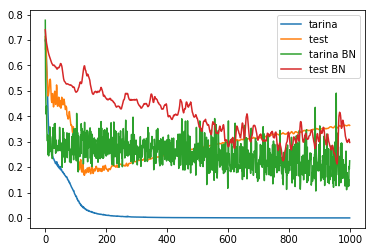

In [11]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

plt.plot(history_Adam_1.history['loss'], label = "tarina BN")
plt.plot(history_Adam_1.history['val_loss'], label = "test BN")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


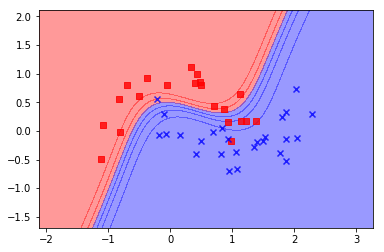

In [12]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [16]:
from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1_l = History()
model = Sequential()
model.add(Dense(1000, use_bias=False,input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(500, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(200, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])
lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_1_l, lrate])






Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1000)              2000      
_________________________________________________________________
batch_normalization_10 (Batc (None, 1000)              4000      
_________________________________________________________________
activation_10 (Activation)   (None, 1000)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 500)               500000    
_________________________________________________________________
batch_normalization_11 (Batc (None, 500)               2000      
_________________________________________________________________
activation_11 (Activation)   (None, 500)              

Epoch 43/1000
53/53 [==============================] - 0s 809us/step - loss: 0.2968 - accuracy: 0.8491 - val_loss: 0.5994 - val_accuracy: 0.7660
Epoch 44/1000
53/53 [==============================] - 0s 828us/step - loss: 0.2445 - accuracy: 0.9245 - val_loss: 0.5983 - val_accuracy: 0.7660
Epoch 45/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2510 - accuracy: 0.9057 - val_loss: 0.5973 - val_accuracy: 0.7660
Epoch 46/1000
53/53 [==============================] - 0s 847us/step - loss: 0.2544 - accuracy: 0.9245 - val_loss: 0.5962 - val_accuracy: 0.7660
Epoch 47/1000
53/53 [==============================] - 0s 734us/step - loss: 0.3570 - accuracy: 0.8491 - val_loss: 0.5952 - val_accuracy: 0.7660
Epoch 48/1000
53/53 [==============================] - 0s 734us/step - loss: 0.3093 - accuracy: 0.8868 - val_loss: 0.5940 - val_accuracy: 0.7660
Epoch 49/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2773 - accuracy: 0.8679 - val_loss: 0.5930 - val_ac

53/53 [==============================] - 0s 715us/step - loss: 0.3454 - accuracy: 0.8491 - val_loss: 0.5344 - val_accuracy: 0.7872
Epoch 100/1000
53/53 [==============================] - 0s 734us/step - loss: 0.3251 - accuracy: 0.8868 - val_loss: 0.5332 - val_accuracy: 0.7872
Epoch 101/1000
53/53 [==============================] - 0s 734us/step - loss: 0.3000 - accuracy: 0.9057 - val_loss: 0.5319 - val_accuracy: 0.7872
Epoch 102/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2707 - accuracy: 0.8868 - val_loss: 0.5306 - val_accuracy: 0.7872
Epoch 103/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2508 - accuracy: 0.9245 - val_loss: 0.5295 - val_accuracy: 0.7872
Epoch 104/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2923 - accuracy: 0.8868 - val_loss: 0.5282 - val_accuracy: 0.7872
Epoch 105/1000
53/53 [==============================] - 0s 772us/step - loss: 0.2722 - accuracy: 0.9057 - val_loss: 0.5270 - val_accuracy: 

53/53 [==============================] - 0s 790us/step - loss: 0.3218 - accuracy: 0.8302 - val_loss: 0.4702 - val_accuracy: 0.8085
Epoch 156/1000
53/53 [==============================] - 0s 772us/step - loss: 0.2940 - accuracy: 0.8302 - val_loss: 0.4692 - val_accuracy: 0.8085
Epoch 157/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2943 - accuracy: 0.8868 - val_loss: 0.4683 - val_accuracy: 0.8085
Epoch 158/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2097 - accuracy: 0.9057 - val_loss: 0.4674 - val_accuracy: 0.8085
Epoch 159/1000
53/53 [==============================] - 0s 772us/step - loss: 0.3128 - accuracy: 0.8868 - val_loss: 0.4665 - val_accuracy: 0.8085
Epoch 160/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2835 - accuracy: 0.9057 - val_loss: 0.4656 - val_accuracy: 0.8085
Epoch 161/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2631 - accuracy: 0.9057 - val_loss: 0.4648 - val_accuracy: 

53/53 [==============================] - 0s 715us/step - loss: 0.2506 - accuracy: 0.8868 - val_loss: 0.4382 - val_accuracy: 0.7872
Epoch 212/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2653 - accuracy: 0.9245 - val_loss: 0.4381 - val_accuracy: 0.7872
Epoch 213/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3196 - accuracy: 0.8491 - val_loss: 0.4380 - val_accuracy: 0.7872
Epoch 214/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2525 - accuracy: 0.9245 - val_loss: 0.4378 - val_accuracy: 0.7872
Epoch 215/1000
53/53 [==============================] - 0s 753us/step - loss: 0.3065 - accuracy: 0.9057 - val_loss: 0.4376 - val_accuracy: 0.7872
Epoch 216/1000
53/53 [==============================] - 0s 696us/step - loss: 0.3793 - accuracy: 0.8302 - val_loss: 0.4378 - val_accuracy: 0.7872
Epoch 217/1000
53/53 [==============================] - 0s 753us/step - loss: 0.3142 - accuracy: 0.8302 - val_loss: 0.4377 - val_accuracy: 

53/53 [==============================] - 0s 715us/step - loss: 0.2377 - accuracy: 0.8868 - val_loss: 0.4519 - val_accuracy: 0.7660
Epoch 268/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2685 - accuracy: 0.9057 - val_loss: 0.4524 - val_accuracy: 0.7660
Epoch 269/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3068 - accuracy: 0.9057 - val_loss: 0.4530 - val_accuracy: 0.7660
Epoch 270/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2929 - accuracy: 0.8868 - val_loss: 0.4535 - val_accuracy: 0.7660
Epoch 271/1000
53/53 [==============================] - 0s 740us/step - loss: 0.3058 - accuracy: 0.8491 - val_loss: 0.4541 - val_accuracy: 0.7660
Epoch 272/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2629 - accuracy: 0.8868 - val_loss: 0.4545 - val_accuracy: 0.7660
Epoch 273/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2982 - accuracy: 0.8868 - val_loss: 0.4554 - val_accuracy: 

53/53 [==============================] - 0s 715us/step - loss: 0.2722 - accuracy: 0.8868 - val_loss: 0.4856 - val_accuracy: 0.7660
Epoch 324/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2752 - accuracy: 0.8679 - val_loss: 0.4862 - val_accuracy: 0.7660
Epoch 325/1000
53/53 [==============================] - 0s 734us/step - loss: 0.3274 - accuracy: 0.8868 - val_loss: 0.4867 - val_accuracy: 0.7660
Epoch 326/1000
53/53 [==============================] - 0s 772us/step - loss: 0.2523 - accuracy: 0.8868 - val_loss: 0.4870 - val_accuracy: 0.7660
Epoch 327/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2849 - accuracy: 0.8868 - val_loss: 0.4875 - val_accuracy: 0.7660
Epoch 328/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2708 - accuracy: 0.8491 - val_loss: 0.4880 - val_accuracy: 0.7660
Epoch 329/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2999 - accuracy: 0.8868 - val_loss: 0.4892 - val_accuracy: 

53/53 [==============================] - 0s 696us/step - loss: 0.3079 - accuracy: 0.9057 - val_loss: 0.5108 - val_accuracy: 0.7660
Epoch 380/1000
53/53 [==============================] - 0s 790us/step - loss: 0.2809 - accuracy: 0.9245 - val_loss: 0.5112 - val_accuracy: 0.7660
Epoch 381/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2964 - accuracy: 0.8679 - val_loss: 0.5113 - val_accuracy: 0.7660
Epoch 382/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2809 - accuracy: 0.8868 - val_loss: 0.5112 - val_accuracy: 0.7660
Epoch 383/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2663 - accuracy: 0.8868 - val_loss: 0.5109 - val_accuracy: 0.7660
Epoch 384/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2664 - accuracy: 0.8679 - val_loss: 0.5111 - val_accuracy: 0.7660
Epoch 385/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2475 - accuracy: 0.9057 - val_loss: 0.5111 - val_accuracy: 

53/53 [==============================] - 0s 809us/step - loss: 0.2954 - accuracy: 0.8679 - val_loss: 0.5155 - val_accuracy: 0.7660
Epoch 436/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2784 - accuracy: 0.8491 - val_loss: 0.5150 - val_accuracy: 0.7660
Epoch 437/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2539 - accuracy: 0.9245 - val_loss: 0.5152 - val_accuracy: 0.7660
Epoch 438/1000
53/53 [==============================] - 0s 772us/step - loss: 0.3148 - accuracy: 0.8302 - val_loss: 0.5156 - val_accuracy: 0.7660
Epoch 439/1000
53/53 [==============================] - 0s 790us/step - loss: 0.2657 - accuracy: 0.8679 - val_loss: 0.5162 - val_accuracy: 0.7660
Epoch 440/1000
53/53 [==============================] - 0s 772us/step - loss: 0.3139 - accuracy: 0.8679 - val_loss: 0.5161 - val_accuracy: 0.7660
Epoch 441/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2564 - accuracy: 0.9057 - val_loss: 0.5163 - val_accuracy: 

53/53 [==============================] - 0s 775us/step - loss: 0.2732 - accuracy: 0.8679 - val_loss: 0.5191 - val_accuracy: 0.7660
Epoch 492/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2727 - accuracy: 0.8868 - val_loss: 0.5192 - val_accuracy: 0.7660
Epoch 493/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2756 - accuracy: 0.8868 - val_loss: 0.5192 - val_accuracy: 0.7660
Epoch 494/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3002 - accuracy: 0.8868 - val_loss: 0.5195 - val_accuracy: 0.7660
Epoch 495/1000
53/53 [==============================] - 0s 734us/step - loss: 0.3524 - accuracy: 0.8113 - val_loss: 0.5200 - val_accuracy: 0.7660
Epoch 496/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2715 - accuracy: 0.9057 - val_loss: 0.5197 - val_accuracy: 0.7660
Epoch 497/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2548 - accuracy: 0.9057 - val_loss: 0.5200 - val_accuracy: 

53/53 [==============================] - 0s 734us/step - loss: 0.3073 - accuracy: 0.8868 - val_loss: 0.5223 - val_accuracy: 0.7660
Epoch 548/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2683 - accuracy: 0.9245 - val_loss: 0.5224 - val_accuracy: 0.7660
Epoch 549/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2459 - accuracy: 0.9057 - val_loss: 0.5223 - val_accuracy: 0.7660
Epoch 550/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2811 - accuracy: 0.8868 - val_loss: 0.5224 - val_accuracy: 0.7660
Epoch 551/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2339 - accuracy: 0.9057 - val_loss: 0.5222 - val_accuracy: 0.7660
Epoch 552/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2371 - accuracy: 0.9245 - val_loss: 0.5222 - val_accuracy: 0.7660
Epoch 553/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2964 - accuracy: 0.9057 - val_loss: 0.5219 - val_accuracy: 

53/53 [==============================] - 0s 715us/step - loss: 0.2621 - accuracy: 0.9057 - val_loss: 0.5236 - val_accuracy: 0.7660
Epoch 604/1000
53/53 [==============================] - 0s 734us/step - loss: 0.3504 - accuracy: 0.8679 - val_loss: 0.5230 - val_accuracy: 0.7660
Epoch 605/1000
53/53 [==============================] - 0s 790us/step - loss: 0.3096 - accuracy: 0.8679 - val_loss: 0.5226 - val_accuracy: 0.7660
Epoch 606/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2799 - accuracy: 0.8679 - val_loss: 0.5225 - val_accuracy: 0.7660
Epoch 607/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2573 - accuracy: 0.8868 - val_loss: 0.5221 - val_accuracy: 0.7660
Epoch 608/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3030 - accuracy: 0.9057 - val_loss: 0.5221 - val_accuracy: 0.7660
Epoch 609/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2614 - accuracy: 0.8679 - val_loss: 0.5221 - val_accuracy: 

53/53 [==============================] - 0s 734us/step - loss: 0.2584 - accuracy: 0.9057 - val_loss: 0.5238 - val_accuracy: 0.7660
Epoch 660/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2660 - accuracy: 0.9057 - val_loss: 0.5239 - val_accuracy: 0.7660
Epoch 661/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3174 - accuracy: 0.8679 - val_loss: 0.5239 - val_accuracy: 0.7660
Epoch 662/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2481 - accuracy: 0.8868 - val_loss: 0.5238 - val_accuracy: 0.7660
Epoch 663/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2878 - accuracy: 0.8491 - val_loss: 0.5238 - val_accuracy: 0.7660
Epoch 664/1000
53/53 [==============================] - 0s 696us/step - loss: 0.2541 - accuracy: 0.9245 - val_loss: 0.5233 - val_accuracy: 0.7660
Epoch 665/1000
53/53 [==============================] - 0s 734us/step - loss: 0.3137 - accuracy: 0.8113 - val_loss: 0.5239 - val_accuracy: 

53/53 [==============================] - 0s 753us/step - loss: 0.2720 - accuracy: 0.9057 - val_loss: 0.5250 - val_accuracy: 0.7660
Epoch 716/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2652 - accuracy: 0.8868 - val_loss: 0.5250 - val_accuracy: 0.7660
Epoch 717/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3127 - accuracy: 0.8679 - val_loss: 0.5252 - val_accuracy: 0.7660
Epoch 718/1000
53/53 [==============================] - 0s 715us/step - loss: 0.2686 - accuracy: 0.8868 - val_loss: 0.5245 - val_accuracy: 0.7660
Epoch 719/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2806 - accuracy: 0.9057 - val_loss: 0.5241 - val_accuracy: 0.7660
Epoch 720/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3207 - accuracy: 0.8868 - val_loss: 0.5247 - val_accuracy: 0.7660
Epoch 721/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2762 - accuracy: 0.8868 - val_loss: 0.5249 - val_accuracy: 

53/53 [==============================] - 0s 677us/step - loss: 0.2630 - accuracy: 0.8679 - val_loss: 0.5248 - val_accuracy: 0.7660
Epoch 772/1000
53/53 [==============================] - 0s 772us/step - loss: 0.3237 - accuracy: 0.8868 - val_loss: 0.5251 - val_accuracy: 0.7660
Epoch 773/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2798 - accuracy: 0.9057 - val_loss: 0.5249 - val_accuracy: 0.7660
Epoch 774/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2493 - accuracy: 0.8868 - val_loss: 0.5248 - val_accuracy: 0.7660
Epoch 775/1000
53/53 [==============================] - 0s 790us/step - loss: 0.2448 - accuracy: 0.8868 - val_loss: 0.5246 - val_accuracy: 0.7660
Epoch 776/1000
53/53 [==============================] - 0s 734us/step - loss: 0.3208 - accuracy: 0.8868 - val_loss: 0.5244 - val_accuracy: 0.7660
Epoch 777/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2989 - accuracy: 0.8491 - val_loss: 0.5248 - val_accuracy: 

53/53 [==============================] - 0s 753us/step - loss: 0.2775 - accuracy: 0.8679 - val_loss: 0.5201 - val_accuracy: 0.7660
Epoch 828/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3162 - accuracy: 0.8679 - val_loss: 0.5196 - val_accuracy: 0.7660
Epoch 829/1000
53/53 [==============================] - 0s 734us/step - loss: 0.3415 - accuracy: 0.8302 - val_loss: 0.5195 - val_accuracy: 0.7660
Epoch 830/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3473 - accuracy: 0.8679 - val_loss: 0.5200 - val_accuracy: 0.7660
Epoch 831/1000
53/53 [==============================] - 0s 715us/step - loss: 0.3010 - accuracy: 0.8868 - val_loss: 0.5200 - val_accuracy: 0.7660
Epoch 832/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2355 - accuracy: 0.9245 - val_loss: 0.5203 - val_accuracy: 0.7660
Epoch 833/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2716 - accuracy: 0.8868 - val_loss: 0.5205 - val_accuracy: 

53/53 [==============================] - 0s 696us/step - loss: 0.3263 - accuracy: 0.8491 - val_loss: 0.5193 - val_accuracy: 0.7660
Epoch 884/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2882 - accuracy: 0.8491 - val_loss: 0.5191 - val_accuracy: 0.7660
Epoch 885/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2849 - accuracy: 0.8868 - val_loss: 0.5194 - val_accuracy: 0.7660
Epoch 886/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2850 - accuracy: 0.8868 - val_loss: 0.5193 - val_accuracy: 0.7660
Epoch 887/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2614 - accuracy: 0.9245 - val_loss: 0.5191 - val_accuracy: 0.7660
Epoch 888/1000
53/53 [==============================] - 0s 753us/step - loss: 0.2995 - accuracy: 0.8868 - val_loss: 0.5190 - val_accuracy: 0.7660
Epoch 889/1000
53/53 [==============================] - 0s 772us/step - loss: 0.4074 - accuracy: 0.8491 - val_loss: 0.5204 - val_accuracy: 

53/53 [==============================] - 0s 734us/step - loss: 0.2640 - accuracy: 0.9057 - val_loss: 0.5193 - val_accuracy: 0.7660
Epoch 940/1000
53/53 [==============================] - 0s 809us/step - loss: 0.3591 - accuracy: 0.8491 - val_loss: 0.5190 - val_accuracy: 0.7660
Epoch 941/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2139 - accuracy: 0.9245 - val_loss: 0.5190 - val_accuracy: 0.7660
Epoch 942/1000
53/53 [==============================] - 0s 753us/step - loss: 0.3206 - accuracy: 0.8679 - val_loss: 0.5188 - val_accuracy: 0.7660
Epoch 943/1000
53/53 [==============================] - 0s 772us/step - loss: 0.2816 - accuracy: 0.9245 - val_loss: 0.5187 - val_accuracy: 0.7660
Epoch 944/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2728 - accuracy: 0.9057 - val_loss: 0.5189 - val_accuracy: 0.7660
Epoch 945/1000
53/53 [==============================] - 0s 866us/step - loss: 0.2247 - accuracy: 0.9057 - val_loss: 0.5191 - val_accuracy: 

53/53 [==============================] - 0s 809us/step - loss: 0.3090 - accuracy: 0.9245 - val_loss: 0.5221 - val_accuracy: 0.7660
Epoch 996/1000
53/53 [==============================] - 0s 828us/step - loss: 0.2906 - accuracy: 0.9057 - val_loss: 0.5215 - val_accuracy: 0.7660
Epoch 997/1000
53/53 [==============================] - 0s 828us/step - loss: 0.3335 - accuracy: 0.8679 - val_loss: 0.5224 - val_accuracy: 0.7660
Epoch 998/1000
53/53 [==============================] - 0s 790us/step - loss: 0.2961 - accuracy: 0.8679 - val_loss: 0.5222 - val_accuracy: 0.7660
Epoch 999/1000
53/53 [==============================] - 0s 772us/step - loss: 0.3461 - accuracy: 0.8679 - val_loss: 0.5228 - val_accuracy: 0.7660
Epoch 1000/1000
53/53 [==============================] - 0s 734us/step - loss: 0.2820 - accuracy: 0.8679 - val_loss: 0.5227 - val_accuracy: 0.7660


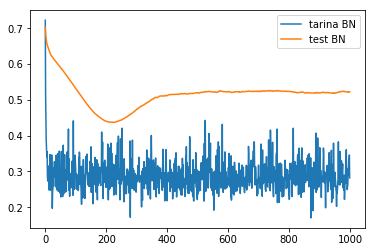

In [17]:
# plt.plot(history_Adam.history['loss'], label = "tarina")
# plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina BN")
# plt.plot(history_Adam_1.history['val_loss'], label = "test BN")

plt.plot(history_Adam_1_l.history['loss'], label = "tarina BN")
plt.plot(history_Adam_1_l.history['val_loss'], label = "test BN")

plt.legend()
plt.show()